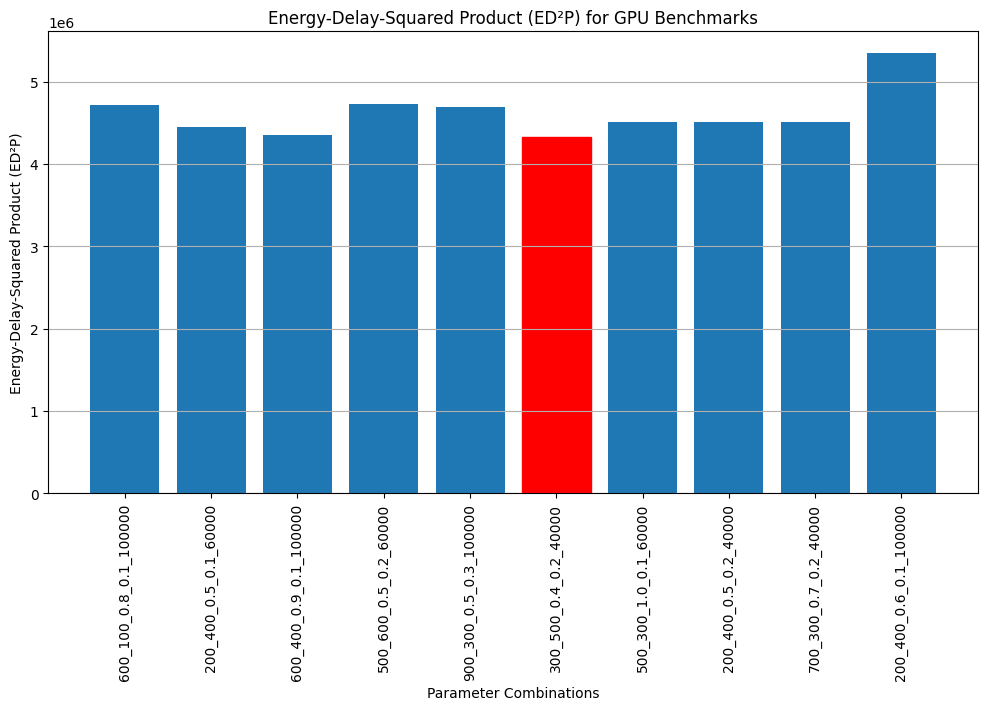

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the current directory
current_dir = "/home/cc/power/GPGPU/data/altis_power_res/no_power_shift/magus_comb/"

# Function to extract runtime from *_gpu.csv file
def extract_runtime(gpu_file):
    try:
        gpu_data = pd.read_csv(gpu_file)
        if "Time (s)" in gpu_data.columns:
            return gpu_data["Time (s)"].iloc[-1]  # Extract last time value
        else:
            print(f"Warning: 'Time (s)' column not found in {gpu_file}")
    except Exception as e:
        print(f"Error reading {gpu_file}: {e}")
    return None

# Collect runtimes
runtime_data = []

def clean_data(df, column_name):
    if column_name in df.columns:
        df[column_name] = df[column_name].apply(lambda x: max(x, 0))  # Replace negatives with 0
    return df

# Function to calculate total energy consumption from CPU and GPU files
def calculate_energy(cpu_file, gpu_file):
    try:
        # Load GPU data
        gpu_data = pd.read_csv(gpu_file)
        gpu_data = clean_data(gpu_data, "GPU 0 Power (W)")

        # Extract time and power for GPU
        time_gpu = gpu_data["Time (s)"].values
        power_gpu = gpu_data["GPU 0 Power (W)"].values

        # Calculate GPU energy using trapezoidal integration
        energy_gpu = sum(
            (power_gpu[i] + power_gpu[i - 1]) / 2 * (time_gpu[i] - time_gpu[i - 1])
            for i in range(1, len(time_gpu))
        )

        # Load CPU data
        cpu_data = pd.read_csv(cpu_file)
        cpu_data = clean_data(cpu_data, "Package Power (W)")

        # Extract time and power for CPU
        time_cpu = cpu_data["Time (s)"].values
        power_cpu = cpu_data["Package Power (W)"].values

        # Calculate CPU energy using trapezoidal integration
        energy_cpu = sum(
            (power_cpu[i] + power_cpu[i - 1]) / 2 * (time_cpu[i] - time_cpu[i - 1])
            for i in range(1, len(time_cpu))
        )

        # Total energy consumption
        return energy_cpu + energy_gpu

    except Exception as e:
        print(f"Error processing {cpu_file} and {gpu_file}: {e}")
        return None

# Collect runtime and energy data
energy_data = []

for file in os.listdir(current_dir):
    if "gpu" in file and file.endswith(".csv"):
        gpu_file_path = os.path.join(current_dir, file)
        cpu_file_path = gpu_file_path.replace("_gpu", "_cpu")  # Find corresponding CPU file

        if os.path.exists(cpu_file_path):
            runtime = extract_runtime(gpu_file_path)
            energy = calculate_energy(cpu_file_path, gpu_file_path)

            if runtime is not None and energy is not None:
                benchmark = file.replace("_.csv", "").replace(".csv", "")
                energy_data.append({"File": file, "Benchmark": benchmark, "Runtime (seconds)": runtime, "Energy (Joules)": energy})

# Convert to DataFrame and display results
df_energy = pd.DataFrame(energy_data)


# if not df_energy.empty:
#     # Create a figure with two subplots for runtime and energy
#     plt.figure(figsize=(14, 6))

#     # Bar plot for runtime
#     plt.subplot(1, 2, 1)
#     plt.bar(df_energy["Benchmark"], df_energy["Runtime (seconds)"], color="blue", alpha=0.7)
#     plt.xlabel("Benchmark")
#     plt.ylabel("Runtime (seconds)")
#     plt.title("Runtime for GPU Benchmarks")
#     plt.xticks(rotation=45)
#     plt.grid(axis="y")

#     # Bar plot for energy
#     plt.subplot(1, 2, 2)
#     plt.bar(df_energy["Benchmark"], df_energy["Energy (Joules)"], color="red", alpha=0.7)
#     plt.xlabel("Benchmark")
#     plt.ylabel("Energy (Joules)")
#     plt.title("Energy Consumption for GPU Benchmarks")
#     plt.xticks(rotation=45)
#     plt.grid(axis="y")

#     # Show the plots
#     plt.tight_layout()
#     plt.show()
# else:
#     print("No valid energy data available to plot.")


if not df_energy.empty:
    df_energy["ED2P"] = df_energy["Runtime (seconds)"]**2 * df_energy["Energy (Joules)"]

    # Find the benchmark with the lowest ED²P value
    min_ed2p_idx = df_energy["ED2P"].idxmin()
    min_ed2p_value = df_energy.loc[min_ed2p_idx, "ED2P"]

    # Extract only the parameter combinations for x-axis labels
    df_energy["Label"] = df_energy["File"].str.extract(r'_(\d+_\d+_\d+\.\d+_\d+\.\d+_\d+)')

    # Create a new figure for the ED²P bar plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(df_energy["Label"], df_energy["ED2P"])

    # Highlight the bar with the lowest ED²P value in red
    bars[min_ed2p_idx].set_color("red")

    plt.xlabel("Parameter Combinations")
    plt.ylabel("Energy-Delay-Squared Product (ED²P)")
    plt.title("Energy-Delay-Squared Product (ED²P) for GPU Benchmarks")
    plt.xticks(rotation=90)
    plt.grid(axis="y")

    # Show the plot
    plt.show()


In [19]:
df_energy["EDP"]

0    4.713709e+06
1    4.451537e+06
2    4.351390e+06
3    4.732394e+06
4    4.692402e+06
5    4.329777e+06
6    4.506308e+06
7    4.507978e+06
8    4.514808e+06
9    5.343203e+06
Name: EDP, dtype: float64